In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Loading the MNIST dataset

In [22]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms, download=True
)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms
)

In [23]:
len(train_dataset), len(test_dataset)

(60000, 10000)

### Creataing validiation dataset

In [24]:
torch.manual_seed(1)
train_subset, val_subset = random_split(train_dataset, [50000, 10000])

# Creating DataLoaders

In [25]:
train_loader = DataLoader(
    train_subset, batch_size=64, shuffle=True
)

val_loader = DataLoader(
    val_subset, batch_size=64, shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [26]:
len(train_loader), len(val_loader), len(test_loader)

(782, 157, 157)

In [27]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    print('labels.shape:', labels.dtype)
    break

images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.int64


### Check label distribution

In [28]:
from collections import Counter

train_counter = Counter()
for _, targets in train_loader:
    train_counter.update(targets.tolist())

val_counter = Counter()
for _, targets in val_loader:
    val_counter.update(targets.tolist())

test_counter = Counter()
for _, targets in test_loader:
    test_counter.update(targets.tolist())

print('Train labels:', sorted(train_counter.items()))
print('Val labels:', sorted(val_counter.items()))
print('Test labels:', sorted(test_counter.items()))


Train labels: [(0, 4901), (1, 5591), (2, 4975), (3, 5146), (4, 4846), (5, 4515), (6, 4943), (7, 5228), (8, 4885), (9, 4970)]
Val labels: [(0, 1022), (1, 1151), (2, 983), (3, 985), (4, 996), (5, 906), (6, 975), (7, 1037), (8, 966), (9, 979)]
Test labels: [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


# Zero-rule baseline (Majority class prediction)

In [29]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 (11.35%)


So if we just always predict class 1, we will be right 11.35% of the time. This is our baseline.

# Quick visual check

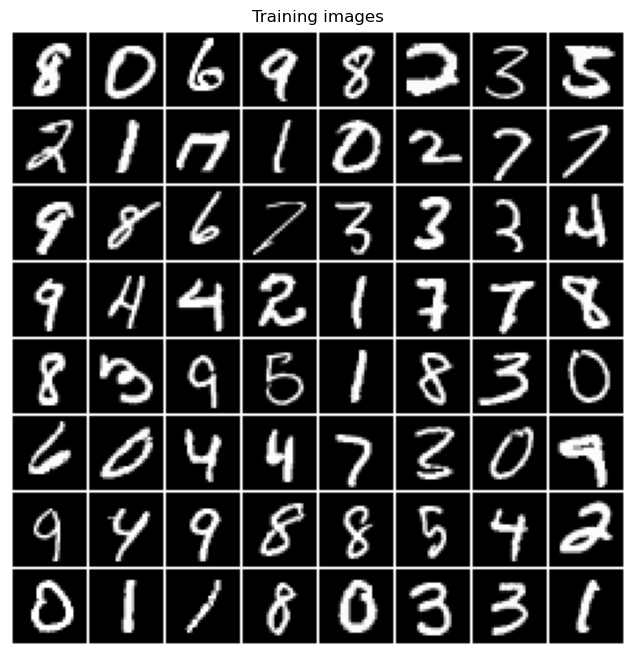

In [30]:
for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images, 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

# Implementing the model

In [31]:
images.shape # batchsize, channel, height, width

torch.Size([64, 1, 28, 28])

In [32]:
# we need to flatten our 28 by 28 matrices into vectorx of 784
torch.flatten(images, start_dim=1).shape # batchsize, features

torch.Size([64, 784])

In [33]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        
        self.all_layers = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes),
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # start dim is the dimension to start flattening
                                          # we start from 1 because we want to keep the batch size
        logits = self.all_layers(x)
        return logits

# Training loop

In [34]:
def compute_accuracy(model, data_loader):
    model.eval()

    correct_pred, num_examples = 0, 0

    for features, labels in data_loader:

        with torch.no_grad():
            logits = model(features)
        

        predictions = torch.argmax(logits, dim=1)
        correct_pred += torch.sum(predictions == labels)
        num_examples += len(labels)
    
    accuracy = correct_pred / num_examples
    return accuracy


In [35]:
torch.manual_seed(1)

learning_rate = 0.01
num_epochs = 15

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultilayerPerceptron(num_features=28*28, num_classes=10)#.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = []
val_loss = []

train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0

    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = model(features)
        
        loss = F.cross_entropy(logits, labels)
        train_loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} | '
                  f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                  f'Loss: {loss:.4f}')

    train_loss_avg = train_loss_sum / len(train_loader)
    train_loss.append(train_loss_avg)

    model.eval()
    with torch.no_grad():
        val_loss_sum = 0
        for batch_idx, (features, labels) in enumerate(val_loader):
            features = features#.to(device)
            labels = labels#.to(device)

            logits = model(features)
            loss = F.cross_entropy(logits, labels)
            val_loss_sum += loss.item()
        
        val_loss_avg = val_loss_sum / len(val_loader)
        val_loss.append(val_loss_avg)
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f'Train Accuracy: {train_acc:.2f}, Validation Accuracy: {val_acc:.2f}')
    train_accs.append(train_acc)
    val_accs.append(val_acc)


Epoch: 01/15 | Batch 000/782 | Loss: 2.3011
Epoch: 01/15 | Batch 200/782 | Loss: 2.2997
Epoch: 01/15 | Batch 400/782 | Loss: 2.2663
Epoch: 01/15 | Batch 600/782 | Loss: 2.1808
Train Accuracy: 0.43, Validation Accuracy: 0.43
Epoch: 02/15 | Batch 000/782 | Loss: 1.8259
Epoch: 02/15 | Batch 200/782 | Loss: 0.8728
Epoch: 02/15 | Batch 400/782 | Loss: 0.8025
Epoch: 02/15 | Batch 600/782 | Loss: 0.6447
Train Accuracy: 0.85, Validation Accuracy: 0.85
Epoch: 03/15 | Batch 000/782 | Loss: 0.5501
Epoch: 03/15 | Batch 200/782 | Loss: 0.5280
Epoch: 03/15 | Batch 400/782 | Loss: 0.3184
Epoch: 03/15 | Batch 600/782 | Loss: 0.4130
Train Accuracy: 0.90, Validation Accuracy: 0.91
Epoch: 04/15 | Batch 000/782 | Loss: 0.3176
Epoch: 04/15 | Batch 200/782 | Loss: 0.2173
Epoch: 04/15 | Batch 400/782 | Loss: 0.4504
Epoch: 04/15 | Batch 600/782 | Loss: 0.3039
Train Accuracy: 0.93, Validation Accuracy: 0.92
Epoch: 05/15 | Batch 000/782 | Loss: 0.1590
Epoch: 05/15 | Batch 200/782 | Loss: 0.2141
Epoch: 05/15 | B

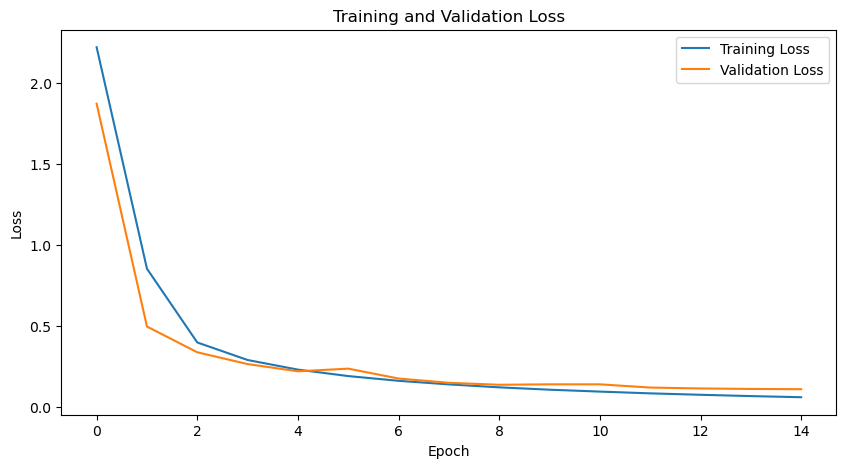

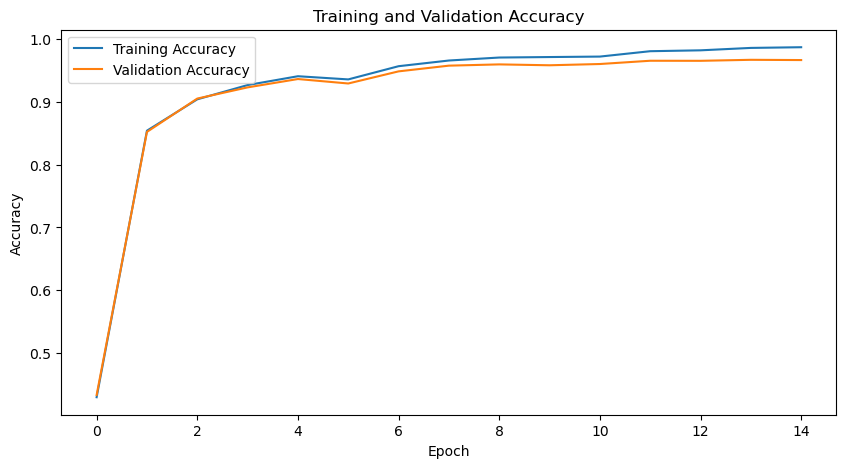

In [36]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot([float(acc) for acc in train_accs], label='Training Accuracy')
plt.plot([float(acc) for acc in val_accs], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)
print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Test Accuracy: {test_acc*100:.2f}%')

Train Accuracy: 98.69%
Validation Accuracy: 96.65%
Test Accuracy: 97.04%


As we can see model is overfitted a little bit.